In [98]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.preprocessing import prepare_data, add_lag_features, add_moving_average_features, add_seasonal_features
from src.tune_hyperparams import tune_lgbm_hyperparameters
from src.utils import plot_feature_importante, calculate_ic, plot_forecast
import seaborn as sns
sns.set_style("dark")
sns.set_palette("dark")

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy import stats
from datetime import date

import json
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LGBM

Para um modelo de árvore para forecast temporal, é muito importante trabalhar em features que reflitam a tendência e sazonalidade dos dados, principalmente, para o case de temperatura.

In [2]:
df = pd.read_csv("../data/jena_climate_2009_2016.csv")
df = prepare_data(df)
target = "temperature_celsius"
df.head()

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,days_since_beginning,year
0,2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000,0,2009
1,2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667,0,2009
2,2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667,0,2009
3,2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333,0,2009
4,2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333,0,2009


# Verificação da correlação

In [3]:
FEATURES = [
    'internal_pressure', 'dew_point',
    'relative_humidity', 'saturation_vapor_pressure', 'vapor_pressure',
    'vapor_pressure_deficit', 'specific_humidity',
    'water_vapor_concentration', 'airtight', 'wind_speed',
    'maximum_wind_speed', 'wind_direction_degree'
]
FEATURES_TIME = [
    "year", 
    "days_since_beginning"
    ]
TARGET = 'temperature_celsius'

In [4]:
corr = df[FEATURES + [TARGET] + FEATURES_TIME].corr()
corr[(0.8<corr.abs())&(corr.abs()<1)].dropna(axis = 1, how="all")

,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,temperature_celsius,year,days_since_beginning
internal_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dew_point,NaN,NaN,0.800722,0.968394,NaN,0.967649,0.968093,-0.886210,0.896856,NaN,NaN
relative_humidity,NaN,NaN,NaN,NaN,-0.843657,NaN,NaN,NaN,NaN,NaN,NaN
saturation_vapor_pressure,0.800722,NaN,NaN,0.826587,0.875782,0.826176,0.826207,-0.901597,0.951204,NaN,NaN
vapor_pressure,0.968394,NaN,0.826587,NaN,NaN,0.999852,0.999856,-0.851406,0.869021,NaN,NaN
vapor_pressure_deficit,NaN,-0.843657,0.875782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
specific_humidity,0.967649,NaN,0.826176,0.999852,NaN,NaN,0.999998,-0.854490,0.868097,NaN,NaN
water_vapor_concentration,0.968093,NaN,0.826207,0.999856,NaN,0.999998,NaN,-0.854932,0.868516,NaN,NaN
airtight,-0.886210,NaN,-0.901597,-0.851406,NaN,-0.854490,-0.854932,NaN,-0.963347,NaN,NaN
wind_speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Correlações entre Features:
- dew_point e vapor_pressure: correlação de 0.968
- dew_point e specific_humidity: correlação de 0.968
- dew_point e water_vapor_concentration: correlação de 0.968
- vapor_pressure e specific_humidity: correlação de 0.999
- vapor_pressure e water_vapor_concentration: correlação de 0.999
- specific_humidity e water_vapor_concentration: correlação de 0.999

- Multicolinearidade Alta entre features: 
    - Há forte multicolinearidade entre `vapor_pressure`, `specific_humidity` e `water_vapor_concentration` (0.999) e também com `dew_point`. Essas variáveis podem ser redundantes e valem ser removidas para reduzir a dimensionalidade do modelo, uma vez que podem introduzir ruído, aumentar chance de overfit e atrapalhar o aprendizado do modelo, além de ser melhor computacionalmente.
    - A `saturation_vapor_pressure` tem uma alta correlação negativa com `airtight`
    - Em relação às variáveis de tempo, o `year` tem uma correlação alta com `days_since_beginning`, ou seja, é possível manter a mais simples (`year`).
- Existe alta correlação entre a target e `saturation_vapor_pressure` e a `dew_point`

In [16]:
FEATURES = [
    'internal_pressure', 
    'dew_point',
    'relative_humidity', 
    'airtight',
    'vapor_pressure_deficit',
    'wind_speed',
    'wind_direction_degree'
]
FEATURES_TIME = [
    "year", 
    ]
corr = df[FEATURES+FEATURES_TIME].corr()
corr[(0.9<corr.abs())&(corr.abs()<1)].dropna(axis = 1, how="all")

""
internal_pressure
dew_point
relative_humidity
airtight
vapor_pressure_deficit
wind_speed
wind_direction_degree
year


## Adicionando componentes sazonais

Uma forma de adicionar sazonalidade de modo que o modelo entenda a periodicidade dos dados é representar o tempo de forma contínua e cíclica usando a decomposição de Fourier (em seno e cosseno). Isso ajuda a capturar a sazonalidade dos dados de maneira suave e contínua, sem a necessidade de variáveis categóricas. Por exemplo, na variável hour, o valor 23 é próximo de 0, mas numericamente são distantes.

Além disso, evita o excesso de variáveis dummies, diminuindo a dimensionalidade do modelo.

In [17]:
df_seas = add_seasonal_features(df, "date")
FEATURES_TIME = ["year", "year_cos","year_sin","month_cos","month_sin","day_cos","day_sin"]
df_seas.head()

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,...,maximum_wind_speed,wind_direction_degree,days_since_beginning,year,year_cos,year_sin,month_cos,month_sin,day_cos,day_sin
0,2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,...,1.002000,174.460000,0,2009,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,...,0.711667,172.416667,0,2009,1.000000,0.000717,0.999962,0.008727,0.965926,0.258819
2,2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,...,0.606667,196.816667,0,2009,0.999999,0.001435,0.999848,0.017452,0.866025,0.500000
3,2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,...,0.606667,157.083333,0,2009,0.999998,0.002152,0.999657,0.026177,0.707107,0.707107
4,2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,...,0.670000,150.093333,0,2009,0.999996,0.002869,0.999391,0.034899,0.500000,0.866025


## Adição de lag

A adição de lag ajuda a capturar a dependência temporal, capturar autocorrelações de curto prazo e ajudando o modelo a aprender o efeito de observações passadas no valor atual. Por exemplo, elas capturam mudanças bruscas ou desvios em relação à sazonalidade, devido a efeitos temporários (ex.: frente fria).

Como essas lags usam apenas valores do passado, elas não introduzem informações do futuro, assim, é possível adicioná-las previamente a quebra de treino e teste.

Além disso, partindo da premissa que os dados de temperatura, pressão, umidade etc. são capturados juntamente a temperatura, é necessário criar lag das features também.


In [19]:
lags = [
    24, 
    48, 
    72, 
    # 365*24
    ]
df_lag = add_lag_features(df_seas, FEATURES+[TARGET], lags = lags)
FEATURES_LAG = [f'{col}_lag_{lag}h' for col in FEATURES+[TARGET] for lag in lags]
df_lag.head()

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,...,wind_direction_degree_lag_48h,temperature_celsius_lag_48h,internal_pressure_lag_72h,dew_point_lag_72h,relative_humidity_lag_72h,airtight_lag_72h,vapor_pressure_deficit_lag_72h,wind_speed_lag_72h,wind_direction_degree_lag_72h,temperature_celsius_lag_72h
0,2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adição de agregações temporais

In [20]:
# calcular média móvel das últimas 24h
window=24
df_mean = add_moving_average_features(df_lag, FEATURES+[TARGET], window=window)
FEATURES_MEAN = [f'{col}_mean_{window}h' for col in FEATURES+[TARGET]]
df_mean.head()

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,...,wind_direction_degree_lag_72h,temperature_celsius_lag_72h,internal_pressure_mean_24h,dew_point_mean_24h,relative_humidity_mean_24h,airtight_mean_24h,vapor_pressure_deficit_mean_24h,wind_speed_mean_24h,wind_direction_degree_mean_24h,temperature_celsius_mean_24h
0,2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,...,NaN,NaN,996.528000,-9.120000,93.780000,1309.196000,0.202000,0.520000,174.460000,-8.304000
1,2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,...,NaN,NaN,996.526500,-8.990833,93.856667,1308.588833,0.201833,0.418333,173.438333,-8.184500
2,2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,...,NaN,NaN,996.599333,-9.197222,93.748889,1309.664778,0.201778,0.361667,181.231111,-8.377444
3,2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,...,NaN,NaN,996.696167,-9.344583,93.611667,1310.451917,0.203833,0.315417,175.194167,-8.507250
4,2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,...,NaN,NaN,996.788600,-9.544667,93.366000,1311.432533,0.209400,0.310333,170.174000,-8.675467


# Tratamento de nulos

Há alguns nulos na base e há duas formas de lidar com eles:
1. Se forem poucos dados ou até a target está nula, uma sugestão é excluir as linhas.
2. Preenchimento de valores: uma opção é usar o forward fill, que preenche os valores nulos com os valores anteriores, mas para que isso seja feito sem vazamento de dados, essa etapa deve ser feita pós separação de dados, em cada quebra de fold.

No caso, há 88 linhas nulas, que representa uma fração muito baixa da base total (0.1%). Assim, a remoção dessas linhas provavelmente não afetará significativamente a qualidade do modelo ou a precisão das previsões. Além disso, como adicionamos features de lag e seno/cosseno, o modelo ainda pode aprender os padrões gerais da série com as informações que restam.

In [21]:
# Carregar os dados (substitua pelo seu dataset)
df_feat = df_mean[df_mean[TARGET].notnull()]
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70041 entries, 0 to 70128
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             70041 non-null  datetime64[ns]
 1   internal_pressure                70041 non-null  float64       
 2   temperature_celsius              70041 non-null  float64       
 3   dew_point                        70041 non-null  float64       
 4   relative_humidity                70041 non-null  float64       
 5   saturation_vapor_pressure        70041 non-null  float64       
 6   vapor_pressure                   70041 non-null  float64       
 7   vapor_pressure_deficit           70041 non-null  float64       
 8   specific_humidity                70041 non-null  float64       
 9   water_vapor_concentration        70041 non-null  float64       
 10  airtight                         70041 non-null  float64       

In [22]:
# removendo linhas com nulos dado a baixa % delas
df_feat = df_feat.dropna(subset=FEATURES_LAG, axis = 0, how = "any")
df_feat.shape

(69846, 54)

# Separação de dados em treino e teste

In [23]:
print("TIME FEATURES: ", FEATURES_TIME)
print("MOV. AVG FEATURES: ", FEATURES_MEAN)
print("LAG FEATURES: ", FEATURES_LAG)

TIME FEATURES:  ['year', 'year_cos', 'year_sin', 'month_cos', 'month_sin', 'day_cos', 'day_sin']
MOV. AVG FEATURES:  ['internal_pressure_mean_24h', 'dew_point_mean_24h', 'relative_humidity_mean_24h', 'airtight_mean_24h', 'vapor_pressure_deficit_mean_24h', 'wind_speed_mean_24h', 'wind_direction_degree_mean_24h', 'temperature_celsius_mean_24h']
LAG FEATURES:  ['internal_pressure_lag_24h', 'internal_pressure_lag_48h', 'internal_pressure_lag_72h', 'dew_point_lag_24h', 'dew_point_lag_48h', 'dew_point_lag_72h', 'relative_humidity_lag_24h', 'relative_humidity_lag_48h', 'relative_humidity_lag_72h', 'airtight_lag_24h', 'airtight_lag_48h', 'airtight_lag_72h', 'vapor_pressure_deficit_lag_24h', 'vapor_pressure_deficit_lag_48h', 'vapor_pressure_deficit_lag_72h', 'wind_speed_lag_24h', 'wind_speed_lag_48h', 'wind_speed_lag_72h', 'wind_direction_degree_lag_24h', 'wind_direction_degree_lag_48h', 'wind_direction_degree_lag_72h', 'temperature_celsius_lag_24h', 'temperature_celsius_lag_48h', 'temperature_

In [24]:
X = df_feat.set_index("date")[FEATURES_LAG + FEATURES_MEAN + FEATURES_TIME]
y = df_feat.set_index("date")[TARGET]
cv=TimeSeriesSplit(n_splits=5)

In [25]:
# Separação inicial de treino e teste
train_end_date = date(2016,9,1)
test_end_date = date(2016,12,31)

X_train = X[X.index.date < train_end_date]
y_train = y[y.index.date < train_end_date]

X_test = X[(X.index.date >= train_end_date) & (X.index.date <= test_end_date)]
y_test = y[(y.index.date >= train_end_date) & (X.index.date <= test_end_date)]

# Feature Selection

In [26]:
# model_raw = lgb.LGBMRegressor(random_state=42, verbose=-1)
# best_params = tune_lgbm_hyperparameters(model_raw, X_train, y_train, cv = cv)

# Inicializando o modelo com os melhores hiperparâmetros encontrados
# model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
# Treinar o modelo
# model.fit(X_train, y_train)

# plot_feature_importante(model, figsize=(10, 5))

In [ ]:
FEATURES_24_48 = []
for features in [FEATURES_LAG + FEATURES_MEAN + FEATURES_TIME]:
    FEATURES_24_48.extend([col for col in features if "72h" not in col])

X = df_feat.set_index("date")[FEATURES_24_48]
y = df_feat.set_index("date")[TARGET]
cv=TimeSeriesSplit(n_splits=5)

# Separação inicial de treino e teste
train_end_date = date(2016,10,1)
test_end_date = date(2016,12,31)

X_train = X[X.index.date < train_end_date]
y_train = y[y.index.date < train_end_date]

X_test = X[(X.index.date >= train_end_date) & (X.index.date <= test_end_date)]
y_test = y[(y.index.date >= train_end_date) & (X.index.date <= test_end_date)]

model_raw = lgb.LGBMRegressor(random_state=42, verbose=-1)
best_params = tune_lgbm_hyperparameters(model_raw, X_train, y_train, cv = cv)

# Inicializando o modelo com os melhores hiperparâmetros encontrados
model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
# Treinar o modelo
model.fit(X_train, y_train)

plot_feature_importante(model, figsize=(10, 5))

In [ ]:
FEATURES_24 = []
for features in [FEATURES_LAG + FEATURES_MEAN + FEATURES_TIME]:
    FEATURES_24.extend([col for col in features if "72h" not in col and "48h" not in col])

X = df_feat.set_index("date")[FEATURES_24]
y = df_feat.set_index("date")[TARGET]
cv=TimeSeriesSplit(n_splits=5)

# Separação inicial de treino e teste
train_end_date = date(2016,10,1)
test_end_date = date(2016,12,31)

X_train = X[X.index.date < train_end_date]
y_train = y[y.index.date < train_end_date]

X_test = X[(X.index.date >= train_end_date) & (X.index.date <= test_end_date)]
y_test = y[(y.index.date >= train_end_date) & (X.index.date <= test_end_date)]


model_raw = lgb.LGBMRegressor(random_state=42, verbose=-1)
best_params = tune_lgbm_hyperparameters(model_raw, X_train, y_train, cv = cv)

# Inicializando o modelo com os melhores hiperparâmetros encontrados
model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
# Treinar o modelo
model.fit(X_train, y_train)

plot_feature_importante(model, figsize=(10, 5))

# Rodar walk-forward validation

In [155]:
len(mae_lst)

116

In [31]:
# 2. Loop de walk-forward validation
mae_lst, dates_lst, y_pred_lst, y_true_lst, rmse_lst = [], [], [], [], []

# Treinamento inicial e loop diário para previsões
current_train_end = pd.to_datetime(train_end_date)

while current_train_end < pd.to_datetime(test_end_date):
    # Definir intervalo de treino e próximo dia de previsão
    X_train_loop = X[X.index.date <= current_train_end.date()]
    y_train_loop = y[y.index.date <= current_train_end.date()]
    next_day = current_train_end + pd.Timedelta(days=1)
    
    # rerun hyperparameter tuning every first day of month
    if current_train_end.day == 1:
        if os.path.isfile(f"../models/hiperparameters/hyperparams_{current_train_end.strftime('%Y%m')}.json"):
            with open(f"../models/hiperparameters/hyperparams_{current_train_end.strftime('%Y%m')}.json", "r") as f:
                best_params = json.load(f)
        else:
            model_raw = lgb.LGBMRegressor(random_state=42, verbose=-1)
            best_params = tune_lgbm_hyperparameters(model_raw, X_train_loop, y_train_loop, cv = cv)
            with open(f"../models/hiperparameters/hyperparams_{current_train_end.strftime('%Y%m')}.json", "w") as f:
                json.dump(best_params, f)
    
    # Inicializando o modelo com os melhores hiperparâmetros encontrados
    model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
    # Treinar o modelo
    model.fit(X_train_loop, y_train_loop)

    # Fazer a previsão para o próximo dia
    X_pred = X[X.index.date == next_day.date()]
    y_true = y[y.index.date == next_day.date()]

    if not X_pred.empty and not y_true.empty:
        y_pred = model.predict(X_pred)
        y_true_lst.append(y_true)
        y_pred_lst.append(y_pred)

        mae = mean_absolute_error(y_true, y_pred)
        mae_lst.append(mae)
        
        rmse = root_mean_squared_error(y_true, y_pred)
        rmse_lst.append(rmse)
        
        dates_lst.append(next_day)
        print(f"MAE do dia {next_day.date()}: {mae}")

    # Avançar para o próximo dia
    current_train_end = next_day

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 48, 'n_estimators': 300, 'num_leaves': 110, 'subsample': 0.9}
MAE do dia 2016-09-02: 1.0939493239518374
MAE do dia 2016-09-03: 0.651071780399331
MAE do dia 2016-09-04: 2.245548132742017
MAE do dia 2016-09-05: 1.2665820426687129
MAE do dia 2016-09-06: 1.417637954222022
MAE do dia 2016-09-07: 2.4984638020473793
MAE do dia 2016-09-08: 0.936607066982512
MAE do dia 2016-09-09: 0.9178513143020844
MAE do dia 2016-09-10: 1.6395972022850558
MAE do dia 2016-09-11: 1.3533693942345042
MAE do dia 2016-09-12: 1.2936783928615012
MAE do dia 2016-09-13: 0.984330920654882
MAE do dia 2016-09-14: 1.1776103385947547
MAE do dia 2016-09-15: 0.8380907417695024
MAE do dia 2016-09-16: 1.0179937569810642
MAE do dia 2016-09-17: 1.4532743203726917
MAE do dia 2016-09-18: 1.2771100367659056
MAE do dia 2016-09-19: 0.6871120665687043
MAE do dia 2

In [50]:
df_temp = pd.concat(y_true_lst).to_frame()

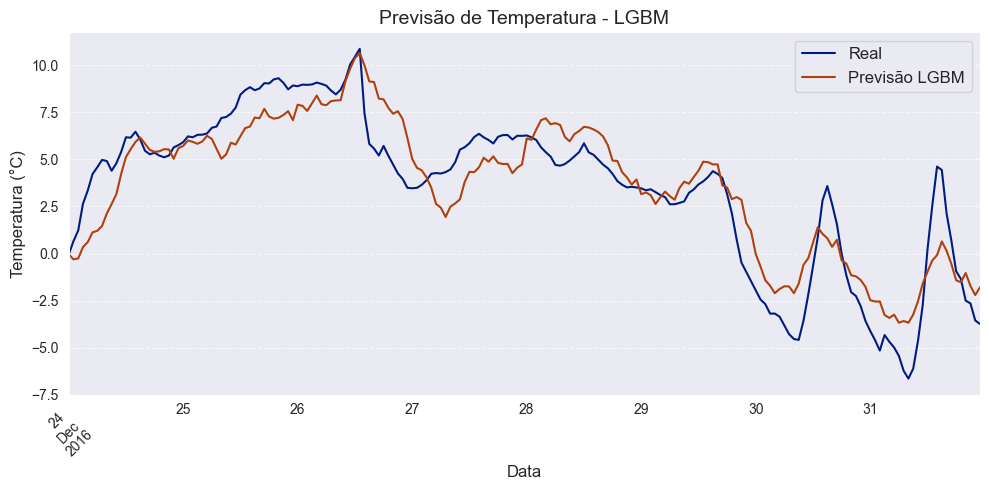

In [52]:
# Plotando as previsões junto com a série original
df_temp = pd.concat(y_true_lst).to_frame()
y_pred_lst_series = []
for i in y_pred_lst:
    y_pred_lst_series.extend(i)

df_temp["y_pred"] = pd.Series(y_pred_lst_series, index=df_temp.index)

legend_labels = ['Real', 'Previsão LGBM']
filter_start_date = date(2016, 12, 23)

plot_forecast(
    y_true=df_temp["temperature_celsius"],
    y_pred=df_temp["y_pred"],
    title='Previsão de Temperatura - LGBM',
    filter_start_date=filter_start_date,
    xlabel='Data',
    ylabel='Temperatura (°C)',
    legend_labels=legend_labels
)

<Axes: >

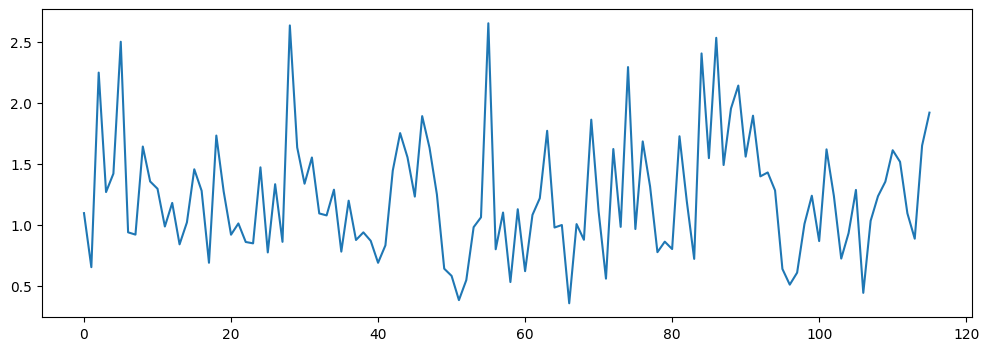

In [33]:
pd.Series(mae_lst).plot(figsize=(12,4))

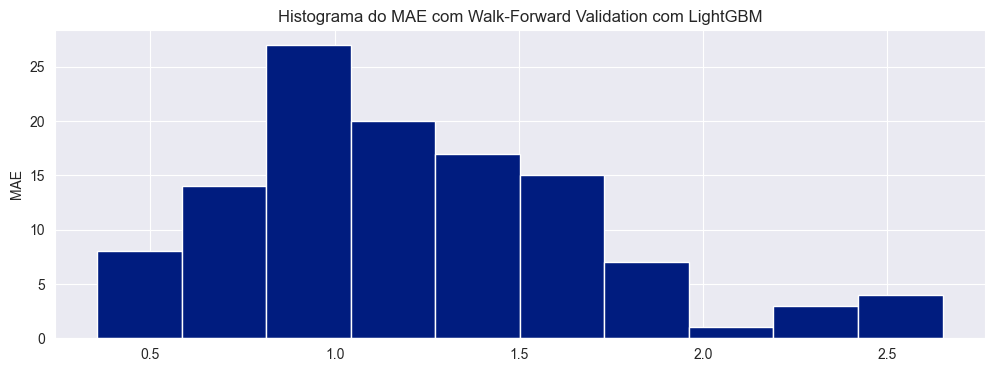

In [40]:
# # 3. Plotar a distribuição do MAE ao longo do tempo
plt.figure(figsize=(12, 4))
plt.hist(mae_lst)
# plt.xlabel('Data')
plt.ylabel('MAE')
plt.title('Histograma do MAE com Walk-Forward Validation com LightGBM')
plt.grid()
plt.show()

In [158]:
ic = calculate_ic(mae_lst, confidence=0.95)
# # Resultados
print(f"N samples: {len(mae_lst)}")
print(f"MAE mean: {np.mean(mae_lst):.4f}")
print(f"MAE desvio padrão: {np.std(mae_lst):.4f}")
print(f"Intervalo de Confiança de 95%: {ic}")

N samples: 116
MAE mean: 1.2242
MAE desvio padrão: 0.4938
Intervalo de Confiança de 95%: (1.133952409693655, 1.314451535596312)


In [154]:
df_temp.to_csv("../data/pred_lgbm.csv")
pd.Series(mae_lst).to_csv("../data/lst_mae_lgbm.csv")